In [1]:
import sys
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from glob import glob
import numpy as np
import torch
from random import shuffle
import random
from numpy import random as npr
import pandas as pd
import imageio
from PIL import Image


class MethaneLoader(DataLoader):

    def __init__(self, device, mode, plume_id, red=False, alli=False, channels=12):
        self.device = device
        self.mode = mode
        self.reduce = red
        self.channels = channels

        if mode == "train":
            persist = False
        else:
            persist = True
        
        if plume_id is not None:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/*/{}.npy".format(mode, plume_id)))
#             self.neg_labels = sorted(
#                 glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/{}.npy".format(mode, plume_id)))
            self.neg_labels = []
        else:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/*.npy".format(mode)))
            self.neg_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/neg/*.npy".format(mode)))

        self.labels = self.pos_labels+self.neg_labels  # None
        
        if not alli:
            self.sample_labels_and_combine(persist=persist)

    def sample_labels_and_combine(self, persist=False):
        """
        Sample a subset of negative labels for each epoch
        """
        # if self.mode == "test":
        if self.mode in ["val"]:
            self.labels = self.pos_labels+self.neg_labels
        else:
            if persist:
                random.seed(555)

            shuffle(self.neg_labels)
            self.labels = self.pos_labels + \
                self.neg_labels[:len(self.pos_labels)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        f = self.labels[index]
        # print(f)

        plume_id = int(f.split("/")[-1].split(".")[0])
        # print(plume_id)

        target = np.load(f)
        context = np.load(
            "/kaggle/input/ch4net-dataset/data/{}/s2/{}.npy".format(self.mode, plume_id))

        if self.channels == 2:
            context = context[..., 10:]
        if self.channels == 5:
            context = np.concatenate(
                [context[..., 1:4], context[..., 10:]], axis=-1)
        
        if self.mode == "train":
            # rotate by 90, 180, 270 degrees
            degrees = npr.choice([0, 90, 180, 270])
            context = np.rot90(context, k=degrees//90)
            target = np.rot90(target, k=degrees//90)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=0)
                target = np.flip(target, axis=0)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=1)
                target = np.flip(target, axis=1)

        # Crop to centre
        # x_c = target.shape[0]//2
        # y_c = target.shape[1]//2
        s = 64

        if self.mode == "train":
            rng = npr.RandomState()
            mid_loc_x = rng.randint(s, target.shape[0]-s)
            mid_loc_y = rng.randint(s, target.shape[1]-s)

        else:
            mid_loc_x = target.shape[0]//2
            mid_loc_y = target.shape[1]//2

        target = target[mid_loc_x-s:mid_loc_x+s,
                        mid_loc_y-s: mid_loc_y+s]

        context = context[mid_loc_x-s:mid_loc_x+s,
                          mid_loc_y-s: mid_loc_y+s, :]

        ### These are not defined before and not necessary for training. 
        ### But these are used in evaluation outputs
#         diff_img = np.array(diff_img[mid_loc_x-s:mid_loc_x+s,
#                                      mid_loc_y-s:mid_loc_y+s, :])
#         diff_img_g = np.array(diff_img_g[mid_loc_x-s:mid_loc_x+s,
#                                          mid_loc_y-s:mid_loc_y+s])
#         rgb_img = np.array(rgb_img[mid_loc_x-s:mid_loc_x+s,
#                                    mid_loc_y-s:mid_loc_y+s, :])

        if self.reduce:
            target = np.array([np.int(target.any())])

        # if self.mode == "test":
            # print("Plume ID: {}, date: {}".format(plume_id, date))

        d = {"pred": torch.from_numpy(context.copy()).float().to(self.device).permute(2, 0, 1)/255,
             "target": torch.from_numpy(target.copy()).float().to(self.device)}
        
        # Print the size of the image tensor
#         print("Image tensor size (context):", d["pred"].size())
#         print("Image tensor size (target):", d["target"].size())

        return d

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    """
    Base MLP module with ReLU activation
    Parameters:
    -----------
    in_channels: Int
        Number of input channels
    out_channels: Int
        Number of output channels
    h_channels: Int
        Number of hidden channels
    h_layers: Int
        Number of hidden layers
    """

    def __init__(self, 
                in_channels, 
                out_channels, 
                h_channels=64,
                h_layers=4):

        super().__init__()

        def hidden_block(h_channels):
            h = nn.Sequential(
            nn.Linear(h_channels, h_channels),
            nn.ReLU())
            return h

        # Model
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.ReLU(),
            *[hidden_block(h_channels) for _ in range(h_layers)],
            nn.Linear(h_channels, out_channels) 
        )

    def forward(self, x):
        return self.mlp(x)

class Unet(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 div_factor=8,
                 prob_output=True,
                 class_output=False

    ):
        super(Unet, self).__init__()

        self.n_channels = in_channels
        self.bilinear = True
        self.sigmoid = nn.Sigmoid()
        self.prob_output = prob_output
        self.class_output = class_output

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                # [?, C, H, W]
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1) ## why 1?
                return self.conv(x)

        self.inc = double_conv(self.n_channels, 64//div_factor)
        self.down1 = down(64//div_factor, 128//div_factor)
        self.down2 = down(128//div_factor, 256//div_factor)
        self.down3 = down(256//div_factor, 512//div_factor)
        self.down4 = down(512//div_factor, 512//div_factor)
        self.up1 = up(1024//div_factor, 256//div_factor)
        self.up2 = up(512//div_factor, 128//div_factor)
        self.up3 = up(256//div_factor, 64//div_factor)
        self.up4 = up(128//div_factor, 128//div_factor)
        self.out = nn.Conv2d(128//div_factor, 1, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        #return self.out(x).permute(0,2,3,1)

        if self.prob_output:
            x = self.out(x)
            return self.sigmoid(x).permute(0,2,3,1)
        else:
            return self.out(x).permute(0,2,3,1)

In [3]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class UNet_Attention(nn.Module):
    def __init__(self, img_ch=12, output_ch=1):
        super(UNet_Attention, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

# Example usage:

# Instantiate the model
model = UNet_Attention(img_ch=12, output_ch=1)

# Example input tensor with shape [batch_size, channels, height, width]
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16

# Example target tensor with shape [batch_size, height, width]
target_tensor = torch.randn(16, 128, 128)

# Adjust the target tensor to match the output shape
target_tensor = target_tensor.unsqueeze(1)

# Forward pass
output = model(input_tensor)

# Check output shape
print(f"Output shape: {output.shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]

Output shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [4]:
import torch
import torch.nn as nn

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [5]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(out_ch))

    def forward(self, x):
        x = self.conv1(x) + self.conv2(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class Res_UNet_Channel_Attention(nn.Module):
    def __init__(self, img_ch=12, output_ch=1):
        super(Res_UNet_Channel_Attention, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16, n1 * 32]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])
        self.conv6 = conv_block(filters[4], filters[5])

        self.Up6 = up_conv(filters[5], filters[4])
        self.Att6 = Attention_block(F_g=filters[4], F_l=filters[4], F_int=filters[3])
        self.Up_conv6 = conv_block(filters[5], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)
        
        self.Ch_att1 = ChannelAttention(in_planes=filters[0], ratio=8)
        self.Ch_att2 = ChannelAttention(in_planes=filters[1], ratio=8)
        self.Ch_att3 = ChannelAttention(in_planes=filters[2], ratio=8)
        self.Ch_att4 = ChannelAttention(in_planes=filters[3], ratio=8)
        self.Ch_att5 = ChannelAttention(in_planes=filters[4], ratio=8)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        e6 = self.Maxpool5(e5)
        e6 = self.conv6(e6)

        d6 = self.Up6(e6)

#         x5 = self.Att6(g=d6, x=self.Ch_att5(e5))
        x5 = self.Att6(g=d6, x=e5)
        d6 = torch.cat((x5, d6), dim=1)
        d6 = self.Up_conv6(d6)

        d5 = self.Up5(d6)
#         x4 = self.Att5(g=d5, x=self.Ch_att4(e4))
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
#         x3 = self.Att4(g=d4, x=self.Ch_att3(e3))
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
#         x2 = self.Att3(g=d3, x=self.Ch_att2(e2))
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
#         x1 = self.Att2(g=d2, x=self.Ch_att1(e1))
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

# Example usage:

# Instantiate the model
model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)

# Example input tensor with shape [batch_size, channels, height, width]
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16

# Example target tensor with shape [batch_size, height, width]
target_tensor = torch.randn(16, 128, 128)

# Adjust the target tensor to match the output shape
target_tensor = target_tensor.unsqueeze(1)

# Forward pass
output = model(input_tensor)

# Check output shape
print(f"Output shape: {output.shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]

Output shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [6]:
from matplotlib import pyplot as plt
import torch
import scipy
import numpy as np
from tqdm import tqdm
from torch import autograd
from torch.utils.data import DataLoader
# from loader import *


class Trainer():
    """
    Training class for the neural process models
    """

    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 train_dataset,
                 loss_function,
                 save_path,
                 learning_rate):

        # Model and data
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.train_dataset = train_dataset
        self.save_path = save_path

        # Training parameters
        self.loss_function = loss_function
        self.opt = torch.optim.Adam(list(model.parameters()) + list(self.loss_function.parameters()), lr=learning_rate)
        self.sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt, mode='min', factor=0.5, patience=7, verbose=True)

        # Losses
        self.losses = []
        self.mIoUs = []

    def plot_losses(self):
        """
        Plot losses and IoUs in same figure
        """
        
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color=color)
        ax1.plot(self.losses, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('mIoU', color=color)
        ax2.plot(self.mIoUs, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()
        plt.show()

    def _unravel_to_numpy(self, x):
        return x.view(-1).detach().cpu().numpy()

    def eval_epoch(self, verbose=False):

        self.model.eval()
        lf = []
        ious = []

        outs = []
        ts = []

        def calculate_iou(pred, target):
            eps = 1e-6
            # convert to sigmoid then to binary
            pred = F.sigmoid(pred)
            pred = (pred > 0.5).float()
            target = target.float()
            
            return (torch.sum(pred * target) + eps) / (torch.sum(pred + target) + eps)
        
        with torch.no_grad():
            for task in self.val_loader:

                out = self.model(task["pred"])
                lf.append(self.loss_function(np.squeeze(out), task["target"]))
                ious.append(calculate_iou(out, task["target"]))
                outs.append(out.detach().cpu().numpy())
                ts.append(task["target"].detach().cpu().numpy())

        # Get loss function
        log_loss = torch.mean(torch.tensor(lf))
        print("- Log loss: {}".format(log_loss))
        mIoU = torch.mean(torch.tensor(ious))
        print("- mIoU: {}".format(mIoU))

        if verbose:
            return log_loss, np.concatenate(outs, axis=0), np.concatenate(ts, axis=0)

        return log_loss, mIoU

    def train(self, n_epochs=100):

        # Init progress bar
        best_loss = 100000
        best_model_state_dict = None
        best_opt_state_dict = None
        i = 1

        for epoch in range(n_epochs):

            autograd.set_detect_anomaly(True)

            print("Training epoch {}".format(epoch))

            if epoch < 500:
                self.model.train()
                self.train_dataset.sample_labels_and_combine()
                self.train_loader = DataLoader(self.train_dataset,
                                               batch_size=16,
                                               shuffle=True)

            with tqdm(self.train_loader, unit="batch") as tepoch:
                for task in tepoch:

                    out = self.model(task["pred"])

                    # print("loss")
                    loss = self.loss_function(np.squeeze(out), task["target"])

                    loss.backward()
                    self.opt.step()
                    self.opt.zero_grad()
                    # print("out")
                    tepoch.set_postfix(loss=loss.item())
                epoch_loss, mIoU = self.eval_epoch(verbose=False)
                self.sched.step(epoch_loss)
#                 print(self.sched.get_last_lr())

            if np.logical_or(epoch_loss <= best_loss, epoch >= 1000):
                #                 torch.save({
                #                     'epoch': epoch,
                #                     'model_state_dict': self.model.state_dict(),
                #                     'optimizer_state_dict': self.opt.state_dict(),
                #                     'loss': epoch_loss
                #                 }, self.save_path+"epoch_{}".format(epoch))
                best_model_state_dict = self.model.state_dict()
                best_opt_state_dict = self.opt.state_dict()
                best_loss = epoch_loss
#                 np.save("outs.npy", o)
#                 np.save("ts.npy", t)

            self.losses.append(epoch_loss)
            self.mIoUs.append(mIoU)

            # checkpoint
            if i % 20 == 0 or i == n_epochs:
                np.save(self.save_path+"losses.npy", np.array(self.losses))
                self.plot_losses()

                torch.save({
                    # 'epoch': epoch,
                    'model_state_dict': best_model_state_dict,
                    'optimizer_state_dict': best_opt_state_dict,
                    'loss': best_loss
                }, self.save_path+"final_model".format(epoch))
            i += 1

        print("Training complete!")

In [7]:
!mkdir -p /kaggle/working/train_out
!mkdir -p /kaggle/working/eval_out

In [8]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.0 MB/s eta 0:00:0000:01


In [9]:
import torch
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss
from monai.losses.hausdorff_loss import HausdorffDTLoss

def loss(pred, target):
#     print(pred.shape, target.shape)
    bce_loss = nn.BCEWithLogitsLoss(reduction="none") 
    ll = bce_loss(pred, target)

    ll = ll.sum(dim=(-2,-1)) #*mask
    return ll.mean()


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce_loss = nn.BCEWithLogitsLoss(reduction="none")
    
    def forward(self, pred, target):
        loss = self.bce_loss(pred, target)
        prob = torch.sigmoid(pred)  # Predicted probability
        alpha = torch.where(target == 1, self.alpha, 1 - self.alpha)  # Class balancing factor
        focal_weight = torch.where(target == 1, 1 - prob, prob)  # Focusing weight
        focal_weight = alpha * focal_weight**self.gamma  # Apply alpha and gamma
        focal_loss = focal_weight * loss
        
        focal_loss = focal_loss.sum(dim=(-2,-1)) #*mask
        
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss

    
class MultiScalePoolingLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2, itr=3, ratio=None):
        super(MultiScalePoolingLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.itr = itr
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma)
        self.ratio = torch.tensor(ratio)
    
    def forward(self, pred, target):
        losses = torch.zeros(self.itr)
        if(pred.dim() == 2):
            pred = pred.unsqueeze(0)
            target = target.unsqueeze(0)
        elif(pred.dim() == 3):
            pred = pred.unsqueeze(1)
            target = target.unsqueeze(1)
        for i in range(self.itr):
            losses[i] = self.focal_loss(pred, target)
            pred = F.max_pool2d(pred, kernel_size=2, stride=2)
            target = F.max_pool2d(target, kernel_size=2, stride=2)
        
        if self.ratio is not None:
            losses = losses * self.ratio
        else:
            losses = losses * 1/self.itr
        
        return torch.sum(losses)

    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        # Flatten label and prediction tensors
        inputs = inputs.view(inputs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        
        # Compute Dice loss
        intersection = (inputs * targets).sum(dim=1)
        dice_loss = 1 - (2.0 * intersection + smooth) / (inputs.sum(dim=1) + targets.sum(dim=1) + smooth)

        # Compute BCE loss
        BCE = F.binary_cross_entropy(inputs, targets, reduction='none')
        BCE = BCE.mean(dim=1)

        # Combine Dice and BCE losses
        Dice_BCE = BCE + dice_loss

        return Dice_BCE.mean()

    
class HausdorffDT_Loss(nn.Module):
    def __init__(self):
        super(HausdorffDT_Loss, self).__init__()
        self.hd_loss = HausdorffDTLoss(reduction='mean', sigmoid=True)
        self.focal_loss = FocalLoss

    def forward(self, inputs, targets):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        return self.hd_loss(inputs.unsqueeze(1), targets.unsqueeze(1))

    
# UncertaintyWeighting
# This method learns to balance multiple losses by considering the homoscedastic uncertainty of each task. 
# It automatically adjusts the relative weights of the losses during training
class HausdorffDT_Focal_Loss(nn.Module):
    def __init__(self, focal_weight = 0.5, hausdorff_weight = 0.5):
        super(HausdorffDT_Focal_Loss, self).__init__()
        self.hd_loss = HausdorffDTLoss(reduction='none', sigmoid=True)
        self.focal_loss = FocalLoss(alpha=0.75, gamma=2.0, reduction='none')
        self.log_vars = nn.Parameter(torch.zeros(2))

    def forward(self, inputs, targets):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        hl = self.hd_loss(inputs.unsqueeze(1), targets.unsqueeze(1))
        fl = self.focal_loss(inputs, targets)
        
        precision1 = torch.exp(-self.log_vars[0])
        loss1 = precision1 * fl + self.log_vars[0]
        
        precision2 = torch.exp(-self.log_vars[1])
        loss2 = precision2 * hl + self.log_vars[1]
        
        return torch.mean(loss1 + loss2)
    

pred = torch.randn(16, 1, 128, 128).float()
target = torch.randint(0, 2, (16, 1, 128, 128)).float()

# focal_loss = FocalLoss(alpha=0.75, gamma=1.0)
# hausdorffDTLoss = HausdorffDT_Loss(reduction='none', sigmoid=True)
# dbceloss = DiceBCELoss()
# multi_scale_pooling_loss = MultiScalePoolingLoss(alpha=0.75, gamma=2.0, itr=3, ratio=[0.5, 0.3, 0.2])
# hausdorffDT_focal_loss = HausdorffDT_Focal_Loss(focal_weight = 0.65)

# focal_loss(pred, target)
# multi_scale_pooling_loss(pred, target)
# print(hausdorffDT_focal_loss(pred, target))

/opt/conda/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


Training epoch 0


  0%|          | 0/75 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/monai/losses/hausdorff_loss.py:171: UserWarning: single channel prediction, `include_background=False` ignored.
  warnings.warn("single channel prediction, `include_background=False` ignored.")
100%|██████████| 75/75 [00:58<00:00,  1.28batch/s, loss=434]   


- Log loss: 347.5018615722656
- mIoU: 0.0010928302071988583
Training epoch 1


100%|██████████| 75/75 [00:34<00:00,  2.15batch/s, loss=226]


- Log loss: 319.8485412597656
- mIoU: 0.002600158331915736
Training epoch 2


100%|██████████| 75/75 [00:34<00:00,  2.15batch/s, loss=321]


- Log loss: 283.4750671386719
- mIoU: 0.0003158559848088771
Training epoch 3


100%|██████████| 75/75 [00:33<00:00,  2.21batch/s, loss=219]


- Log loss: 264.3439636230469
- mIoU: 9.090574167203158e-06
Training epoch 4


100%|██████████| 75/75 [00:33<00:00,  2.21batch/s, loss=224]


- Log loss: 281.9169006347656
- mIoU: 0.0034970028791576624
Training epoch 5


100%|██████████| 75/75 [00:33<00:00,  2.25batch/s, loss=285]


- Log loss: 280.6295166015625
- mIoU: 0.004766152240335941
Training epoch 6


100%|██████████| 75/75 [00:33<00:00,  2.26batch/s, loss=281]


- Log loss: 270.4620666503906
- mIoU: 0.003626215038821101
Training epoch 7


100%|██████████| 75/75 [00:32<00:00,  2.29batch/s, loss=246]


- Log loss: 263.92779541015625
- mIoU: 0.005273414310067892
Training epoch 8


100%|██████████| 75/75 [00:32<00:00,  2.31batch/s, loss=309]


- Log loss: 262.5332336425781
- mIoU: 8.229742525145411e-05
Training epoch 9


100%|██████████| 75/75 [00:32<00:00,  2.30batch/s, loss=293] 


- Log loss: 249.36065673828125
- mIoU: 0.0012522434117272496
Training epoch 10


100%|██████████| 75/75 [00:31<00:00,  2.36batch/s, loss=209]


- Log loss: 245.72642517089844
- mIoU: 0.008209258317947388
Training epoch 11


100%|██████████| 75/75 [00:31<00:00,  2.37batch/s, loss=382]


- Log loss: 244.50689697265625
- mIoU: 0.0003416359832044691
Training epoch 12


100%|██████████| 75/75 [00:31<00:00,  2.40batch/s, loss=252]


- Log loss: 247.82566833496094
- mIoU: 0.008338945917785168
Training epoch 13


100%|██████████| 75/75 [00:31<00:00,  2.38batch/s, loss=205]


- Log loss: 286.3158874511719
- mIoU: 0.01734696887433529
Training epoch 14


100%|██████████| 75/75 [00:30<00:00,  2.43batch/s, loss=196]


- Log loss: 205.6421356201172
- mIoU: 0.013918612152338028
Training epoch 15


100%|██████████| 75/75 [00:30<00:00,  2.44batch/s, loss=210] 


- Log loss: 204.8040771484375
- mIoU: 0.013347242958843708
Training epoch 16


100%|██████████| 75/75 [00:30<00:00,  2.43batch/s, loss=169]


- Log loss: 191.71902465820312
- mIoU: 0.01343362033367157
Training epoch 17


100%|██████████| 75/75 [00:30<00:00,  2.46batch/s, loss=225]


- Log loss: 195.81439208984375
- mIoU: 0.014735480770468712
Training epoch 18


100%|██████████| 75/75 [00:30<00:00,  2.45batch/s, loss=148] 


- Log loss: 191.92147827148438
- mIoU: 0.02212066389620304
Training epoch 19


100%|██████████| 75/75 [00:30<00:00,  2.48batch/s, loss=118] 


- Log loss: 190.1236114501953
- mIoU: 0.02673989348113537


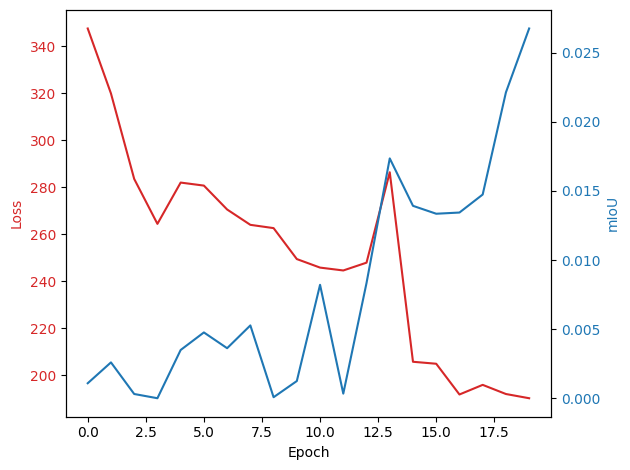

Training epoch 20


100%|██████████| 75/75 [00:30<00:00,  2.47batch/s, loss=160] 


- Log loss: 208.704345703125
- mIoU: 0.011910013854503632
Training epoch 21


100%|██████████| 75/75 [00:29<00:00,  2.51batch/s, loss=140] 


- Log loss: 189.28468322753906
- mIoU: 0.02806667611002922
Training epoch 22


100%|██████████| 75/75 [00:29<00:00,  2.52batch/s, loss=112] 


- Log loss: 225.53695678710938
- mIoU: 0.018319174647331238
Training epoch 23


100%|██████████| 75/75 [00:29<00:00,  2.52batch/s, loss=151] 


- Log loss: 204.64060974121094
- mIoU: 0.02858448401093483
Training epoch 24


100%|██████████| 75/75 [00:29<00:00,  2.52batch/s, loss=152] 


- Log loss: 224.94821166992188
- mIoU: 0.014740744605660439
Training epoch 25


100%|██████████| 75/75 [00:29<00:00,  2.53batch/s, loss=365] 


- Log loss: 164.5503387451172
- mIoU: 0.03130023926496506
Training epoch 26


100%|██████████| 75/75 [00:29<00:00,  2.55batch/s, loss=116] 


- Log loss: 177.0030059814453
- mIoU: 0.026175454258918762
Training epoch 27


100%|██████████| 75/75 [00:29<00:00,  2.55batch/s, loss=134] 


- Log loss: 164.88095092773438
- mIoU: 0.029393306002020836
Training epoch 28


100%|██████████| 75/75 [00:29<00:00,  2.55batch/s, loss=201] 


- Log loss: 198.06375122070312
- mIoU: 0.02289322018623352
Training epoch 29


100%|██████████| 75/75 [00:29<00:00,  2.56batch/s, loss=125] 


- Log loss: 164.7357635498047
- mIoU: 0.038460563868284225
Training epoch 30


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=179] 


- Log loss: 175.74945068359375
- mIoU: 0.02943221852183342
Training epoch 31


100%|██████████| 75/75 [00:29<00:00,  2.57batch/s, loss=114] 


- Log loss: 183.86721801757812
- mIoU: 0.024451807141304016
Training epoch 32


100%|██████████| 75/75 [00:29<00:00,  2.58batch/s, loss=170] 


- Log loss: 201.62103271484375
- mIoU: 0.030605997890233994
Training epoch 33


100%|██████████| 75/75 [00:29<00:00,  2.56batch/s, loss=119] 


- Log loss: 155.7519989013672
- mIoU: 0.030927786603569984
Training epoch 34


100%|██████████| 75/75 [00:29<00:00,  2.58batch/s, loss=101] 


- Log loss: 149.64242553710938
- mIoU: 0.03707348555326462
Training epoch 35


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=187] 


- Log loss: 140.04888916015625
- mIoU: 0.03712935373187065
Training epoch 36


100%|██████████| 75/75 [00:29<00:00,  2.57batch/s, loss=71.3]


- Log loss: 154.71737670898438
- mIoU: 0.02661326713860035
Training epoch 37


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=99.6]


- Log loss: 146.83082580566406
- mIoU: 0.024899013340473175
Training epoch 38


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=130] 


- Log loss: 139.97398376464844
- mIoU: 0.031809255480766296
Training epoch 39


100%|██████████| 75/75 [00:28<00:00,  2.60batch/s, loss=126] 


- Log loss: 144.9969024658203
- mIoU: 0.036583319306373596


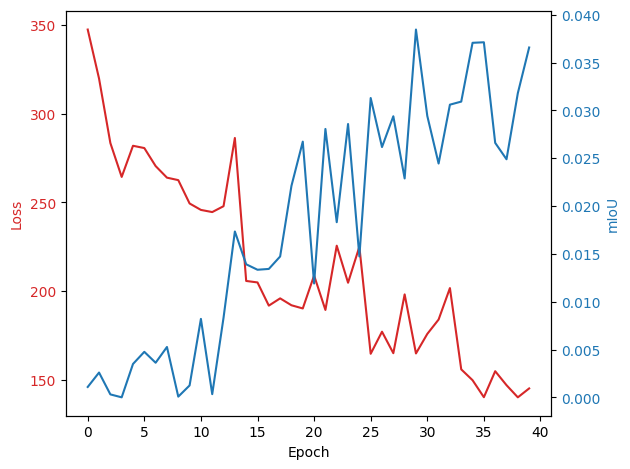

Training epoch 40


100%|██████████| 75/75 [00:29<00:00,  2.57batch/s, loss=272] 


- Log loss: 131.531005859375
- mIoU: 0.03191041946411133
Training epoch 41


100%|██████████| 75/75 [00:29<00:00,  2.53batch/s, loss=118] 


- Log loss: 143.15234375
- mIoU: 0.020809249952435493
Training epoch 42


100%|██████████| 75/75 [00:29<00:00,  2.59batch/s, loss=95.6]


- Log loss: 129.23497009277344
- mIoU: 0.036067526787519455
Training epoch 43


100%|██████████| 75/75 [00:29<00:00,  2.57batch/s, loss=107] 


- Log loss: 133.5276336669922
- mIoU: 0.034994937479496
Training epoch 44


100%|██████████| 75/75 [00:29<00:00,  2.58batch/s, loss=115] 


- Log loss: 112.94637298583984
- mIoU: 0.04157537221908569
Training epoch 45


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=118] 


- Log loss: 151.4390411376953
- mIoU: 0.025506988167762756
Training epoch 46


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=69.7]


- Log loss: 139.0890350341797
- mIoU: 0.033152420073747635
Training epoch 47


100%|██████████| 75/75 [00:28<00:00,  2.60batch/s, loss=107] 


- Log loss: 120.46085357666016
- mIoU: 0.035141732543706894
Training epoch 48


100%|██████████| 75/75 [00:28<00:00,  2.60batch/s, loss=168] 


- Log loss: 126.99451446533203
- mIoU: 0.03692037984728813
Training epoch 49


100%|██████████| 75/75 [00:29<00:00,  2.58batch/s, loss=93.4]


- Log loss: 111.71200561523438
- mIoU: 0.043781258165836334
Training epoch 50


100%|██████████| 75/75 [00:29<00:00,  2.57batch/s, loss=103] 


- Log loss: 112.40008544921875
- mIoU: 0.041595786809921265
Training epoch 51


100%|██████████| 75/75 [00:29<00:00,  2.58batch/s, loss=185] 


- Log loss: 124.13855743408203
- mIoU: 0.03512042388319969
Training epoch 52


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=86.9]


- Log loss: 137.4661407470703
- mIoU: 0.02609509974718094
Training epoch 53


100%|██████████| 75/75 [00:29<00:00,  2.57batch/s, loss=77.4]


- Log loss: 116.3226318359375
- mIoU: 0.06291187554597855
Training epoch 54


100%|██████████| 75/75 [00:28<00:00,  2.60batch/s, loss=106] 


- Log loss: 114.3663101196289
- mIoU: 0.03704370930790901
Training epoch 55


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=63.1]


- Log loss: 127.95063018798828
- mIoU: 0.033966101706027985
Training epoch 56


100%|██████████| 75/75 [00:28<00:00,  2.60batch/s, loss=66.5]


- Log loss: 112.66655731201172
- mIoU: 0.036869216710329056
Training epoch 57


100%|██████████| 75/75 [00:29<00:00,  2.56batch/s, loss=62.9]


- Log loss: 118.74922943115234
- mIoU: 0.030828101560473442
Training epoch 58


100%|██████████| 75/75 [00:29<00:00,  2.58batch/s, loss=69.4]


- Log loss: 108.48606872558594
- mIoU: 0.03954964876174927
Training epoch 59


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=75.8]


- Log loss: 106.50856018066406
- mIoU: 0.040437161922454834


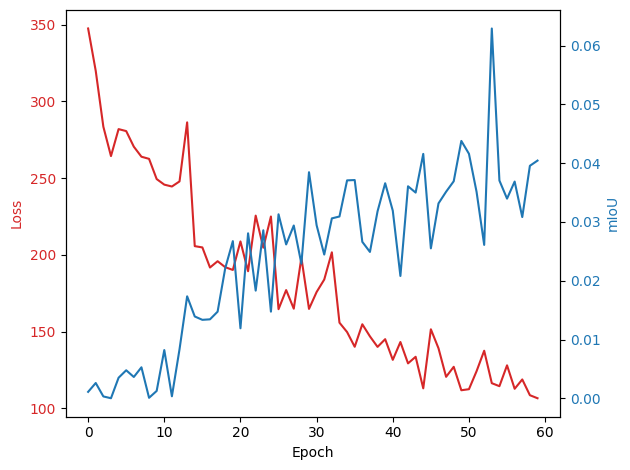

Training epoch 60


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=104] 


- Log loss: 112.46344757080078
- mIoU: 0.03744559362530708
Training epoch 61


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=48]  


- Log loss: 101.6707763671875
- mIoU: 0.04031131789088249
Training epoch 62


100%|██████████| 75/75 [00:29<00:00,  2.58batch/s, loss=57.1]


- Log loss: 103.01724243164062
- mIoU: 0.038086339831352234
Training epoch 63


100%|██████████| 75/75 [00:28<00:00,  2.60batch/s, loss=83.6]


- Log loss: 102.5651626586914
- mIoU: 0.04059493914246559
Training epoch 64


100%|██████████| 75/75 [00:28<00:00,  2.62batch/s, loss=116] 


- Log loss: 102.79755401611328
- mIoU: 0.0382569320499897
Training epoch 65


100%|██████████| 75/75 [00:29<00:00,  2.55batch/s, loss=91.2]


- Log loss: 101.07453155517578
- mIoU: 0.03857618570327759
Training epoch 66


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=44.8]


- Log loss: 105.85498809814453
- mIoU: 0.04141237214207649
Training epoch 67


100%|██████████| 75/75 [00:28<00:00,  2.60batch/s, loss=68.9]


- Log loss: 127.59518432617188
- mIoU: 0.034326668828725815
Training epoch 68


100%|██████████| 75/75 [00:28<00:00,  2.62batch/s, loss=66.5]


- Log loss: 101.22978210449219
- mIoU: 0.043083593249320984
Training epoch 69


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=55.2]


- Log loss: 96.3405990600586
- mIoU: 0.042391110211610794
Training epoch 70


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=52.4]


- Log loss: 111.57073211669922
- mIoU: 0.03562579303979874
Training epoch 71


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=69.1]


- Log loss: 108.6449203491211
- mIoU: 0.0380672961473465
Training epoch 72


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=76.7]


- Log loss: 95.85945892333984
- mIoU: 0.04123326390981674
Training epoch 73


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=69]  


- Log loss: 97.43202209472656
- mIoU: 0.04414210841059685
Training epoch 74


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=39.8]


- Log loss: 104.213623046875
- mIoU: 0.03784957900643349
Training epoch 75


100%|██████████| 75/75 [00:28<00:00,  2.60batch/s, loss=66.5]


- Log loss: 109.37883758544922
- mIoU: 0.03849207982420921
Training epoch 76


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=70.3]


- Log loss: 93.81497192382812
- mIoU: 0.043172843754291534
Training epoch 77


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=67.6]


- Log loss: 103.89614868164062
- mIoU: 0.04216710105538368
Training epoch 78


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=87.6]


- Log loss: 103.0504150390625
- mIoU: 0.03604058921337128
Training epoch 79


100%|██████████| 75/75 [00:28<00:00,  2.62batch/s, loss=61.1]


- Log loss: 90.3866958618164
- mIoU: 0.04340212792158127


Training epoch 80


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=75]  


- Log loss: 94.74496459960938
- mIoU: 0.03698073700070381
Training epoch 81


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=46.1]


- Log loss: 92.29813385009766
- mIoU: 0.043514370918273926
Training epoch 82


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=30.4]


- Log loss: 94.88430786132812
- mIoU: 0.042255278676748276
Training epoch 83
- Log loss: 88.45089721679688
- mIoU: 0.0438842847943306
Training epoch 86


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=25.5]


- Log loss: 84.01749420166016
- mIoU: 0.042351819574832916
Training epoch 87


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=36.3]


- Log loss: 106.81072235107422
- mIoU: 0.0382869690656662
Training epoch 88


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=67.4]


- Log loss: 92.34780883789062
- mIoU: 0.04179730266332626
Training epoch 89


100%|██████████| 75/75 [00:28<00:00,  2.65batch/s, loss=74.5]


- Log loss: 95.54818725585938
- mIoU: 0.03675416111946106
Training epoch 90


100%|██████████| 75/75 [00:28<00:00,  2.65batch/s, loss=75.9]


- Log loss: 100.75492858886719
- mIoU: 0.04061403125524521
Training epoch 91


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=49.7]


- Log loss: 101.119140625
- mIoU: 0.03764345124363899
Training epoch 92


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=69.6]


- Log loss: 93.0421371459961
- mIoU: 0.039355915039777756
Training epoch 93


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=60.3]


- Log loss: 106.66813659667969
- mIoU: 0.036336131393909454
Training epoch 94


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=54.1]


- Log loss: 85.40572357177734
- mIoU: 0.04080246388912201
Training epoch 95


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=81.7]


- Log loss: 86.34156036376953
- mIoU: 0.040595732629299164
Training epoch 96


100%|██████████| 75/75 [00:29<00:00,  2.56batch/s, loss=47.3]


- Log loss: 80.1156997680664
- mIoU: 0.041720200330019
Training epoch 97


100%|██████████| 75/75 [00:29<00:00,  2.52batch/s, loss=44.9]


- Log loss: 84.0514907836914
- mIoU: 0.04160155728459358
Training epoch 98


100%|██████████| 75/75 [00:29<00:00,  2.58batch/s, loss=65.2]


- Log loss: 85.56766510009766
- mIoU: 0.04264981299638748
Training epoch 99


100%|██████████| 75/75 [00:28<00:00,  2.65batch/s, loss=49]  


- Log loss: 84.1854476928711
- mIoU: 0.0421849861741066


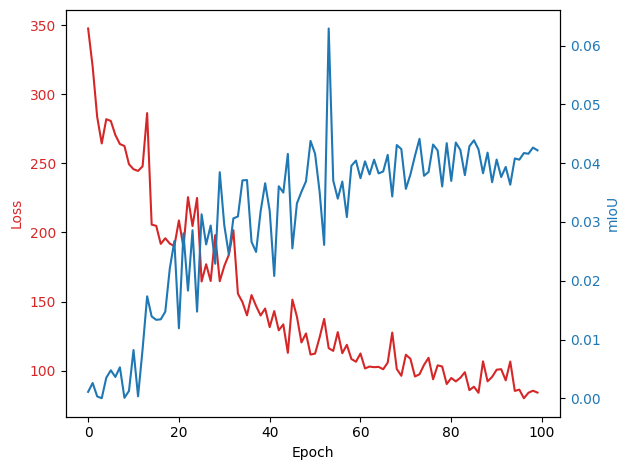

Training epoch 100


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=70.5]


- Log loss: 89.2056884765625
- mIoU: 0.04302457720041275
Training epoch 101


100%|██████████| 75/75 [00:28<00:00,  2.62batch/s, loss=93]  


- Log loss: 94.44212341308594
- mIoU: 0.04179435968399048
Training epoch 102


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=57.8]


- Log loss: 86.85440063476562
- mIoU: 0.04323642700910568
Training epoch 103


100%|██████████| 75/75 [00:28<00:00,  2.62batch/s, loss=45.4]


- Log loss: 93.05648040771484
- mIoU: 0.04147131368517876
Training epoch 104


100%|██████████| 75/75 [00:29<00:00,  2.58batch/s, loss=47]  


- Log loss: 85.09400939941406
- mIoU: 0.04496855288743973
Training epoch 105


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=28.8]


- Log loss: 84.05648803710938
- mIoU: 0.04509323462843895
Training epoch 106


100%|██████████| 75/75 [00:28<00:00,  2.62batch/s, loss=45.2]


- Log loss: 85.72415924072266
- mIoU: 0.04396761581301689
Training epoch 107


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=28.5]


- Log loss: 90.64158630371094
- mIoU: 0.04477253556251526
Training epoch 108


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=37.2]


- Log loss: 87.50920867919922
- mIoU: 0.04493599012494087
Training epoch 109


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=35.2]


- Log loss: 79.70368957519531
- mIoU: 0.04353921487927437
Training epoch 110


100%|██████████| 75/75 [00:28<00:00,  2.66batch/s, loss=47.1]


- Log loss: 82.23785400390625
- mIoU: 0.044366173446178436
Training epoch 111


100%|██████████| 75/75 [00:28<00:00,  2.65batch/s, loss=55.3]


- Log loss: 81.6265869140625
- mIoU: 0.04231944680213928
Training epoch 112


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=72.1]


- Log loss: 84.49808502197266
- mIoU: 0.0429438017308712
Training epoch 113


100%|██████████| 75/75 [00:28<00:00,  2.65batch/s, loss=40.5]


- Log loss: 83.63838958740234
- mIoU: 0.040409982204437256
Training epoch 114


100%|██████████| 75/75 [00:28<00:00,  2.65batch/s, loss=57]  


- Log loss: 81.91039276123047
- mIoU: 0.045088741928339005
Training epoch 115


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=44.3]


- Log loss: 83.86675262451172
- mIoU: 0.04311220347881317
Training epoch 116


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=50]  


- Log loss: 85.87699890136719
- mIoU: 0.043546415865421295
Training epoch 117


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=56.8]


- Log loss: 82.50348663330078
- mIoU: 0.043665703386068344
Training epoch 118


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=38.9]


- Log loss: 82.76776123046875
- mIoU: 0.045252881944179535
Training epoch 119


100%|██████████| 75/75 [00:28<00:00,  2.66batch/s, loss=60.4]


- Log loss: 81.37104034423828
- mIoU: 0.04433780163526535


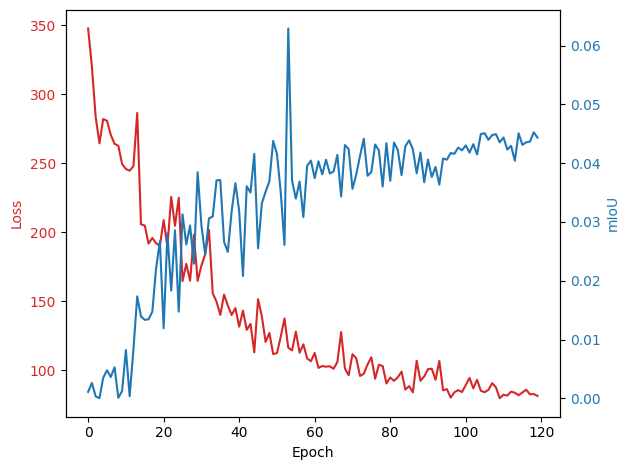

Training epoch 120


100%|██████████| 75/75 [00:28<00:00,  2.60batch/s, loss=42]  


- Log loss: 82.20738220214844
- mIoU: 0.04472855105996132
Training epoch 121


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=27.3]


- Log loss: 79.4561538696289
- mIoU: 0.04474218189716339
Training epoch 122


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=62.8]


- Log loss: 77.80838775634766
- mIoU: 0.04441263526678085
Training epoch 123


100%|██████████| 75/75 [00:28<00:00,  2.65batch/s, loss=54.2]


- Log loss: 81.79496002197266
- mIoU: 0.04599546641111374
Training epoch 124


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=41.7]


- Log loss: 83.01537322998047
- mIoU: 0.04552853852510452
Training epoch 125


100%|██████████| 75/75 [00:28<00:00,  2.66batch/s, loss=64.6]


- Log loss: 83.47737121582031
- mIoU: 0.04435976967215538
Training epoch 126


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=34.4]


- Log loss: 83.02129364013672
- mIoU: 0.04380793496966362
Training epoch 127


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=41.4]


- Log loss: 81.02688598632812
- mIoU: 0.04551593214273453
Training epoch 128


100%|██████████| 75/75 [00:28<00:00,  2.60batch/s, loss=37.3]


- Log loss: 87.75579833984375
- mIoU: 0.043085262179374695
Training epoch 129


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=55.1]


- Log loss: 84.13639831542969
- mIoU: 0.04489089921116829
Training epoch 130


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=41.5]


- Log loss: 83.43327331542969
- mIoU: 0.04380439594388008
Training epoch 131


100%|██████████| 75/75 [00:28<00:00,  2.65batch/s, loss=42.3]


- Log loss: 83.92991638183594
- mIoU: 0.04457633197307587
Training epoch 132


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=52.7]


- Log loss: 81.63801574707031
- mIoU: 0.043662648648023605
Training epoch 133


100%|██████████| 75/75 [00:28<00:00,  2.65batch/s, loss=49.9]


- Log loss: 81.90904998779297
- mIoU: 0.04291486740112305
Training epoch 134


100%|██████████| 75/75 [00:28<00:00,  2.66batch/s, loss=45.6]


- Log loss: 84.41861724853516
- mIoU: 0.044662948697805405
Training epoch 135


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=42.9]


- Log loss: 81.16099548339844
- mIoU: 0.04368682578206062
Training epoch 136


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=65.2]


- Log loss: 81.121826171875
- mIoU: 0.04502309113740921
Training epoch 137


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=39.3]


- Log loss: 80.9302978515625
- mIoU: 0.046003203839063644
Training epoch 138


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=23.4]


- Log loss: 80.8951416015625
- mIoU: 0.04348471388220787
Training epoch 139


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=48.9]


- Log loss: 79.79212951660156
- mIoU: 0.04460114240646362


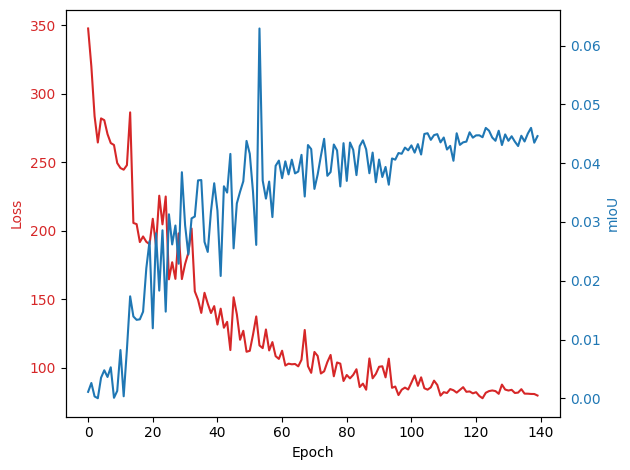

Training epoch 140


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=41.9]


- Log loss: 80.02593994140625
- mIoU: 0.04562031477689743
Training epoch 141


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=48.5]


- Log loss: 81.65176391601562
- mIoU: 0.04392503574490547
Training epoch 142


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=25.1]


- Log loss: 80.47099304199219
- mIoU: 0.04528633505105972
Training epoch 143


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=28.6]


- Log loss: 80.80292510986328
- mIoU: 0.0456506721675396
Training epoch 144


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=41.5]


- Log loss: 82.95406341552734
- mIoU: 0.04253770038485527
Training epoch 145


100%|██████████| 75/75 [00:28<00:00,  2.65batch/s, loss=90.2]


- Log loss: 80.22514343261719
- mIoU: 0.04445434361696243
Training epoch 146


100%|██████████| 75/75 [00:28<00:00,  2.66batch/s, loss=37.1]


- Log loss: 81.04389190673828
- mIoU: 0.043413057923316956
Training epoch 147


100%|██████████| 75/75 [00:28<00:00,  2.66batch/s, loss=39.3]


- Log loss: 79.63159942626953
- mIoU: 0.04708337411284447
Training epoch 148


100%|██████████| 75/75 [00:28<00:00,  2.62batch/s, loss=23.2]


- Log loss: 81.52426147460938
- mIoU: 0.04547450318932533
Training epoch 149


100%|██████████| 75/75 [00:28<00:00,  2.66batch/s, loss=29]  


- Log loss: 81.00936126708984
- mIoU: 0.04443269968032837


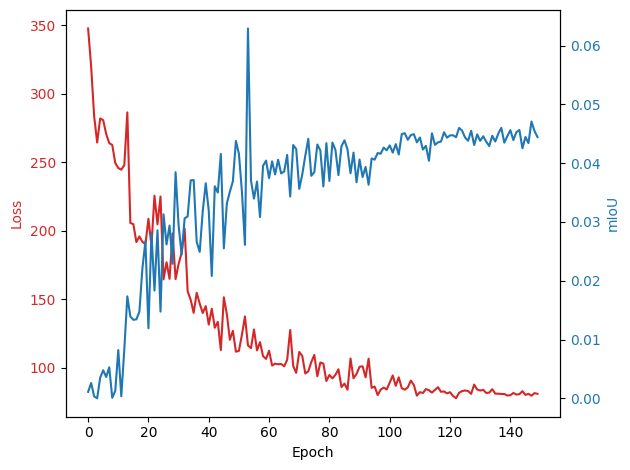

Training complete!


In [10]:
# from models import *
# from trainer import *
# from loader import *
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.multivariate_normal import MultivariateNormal
import sys

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel

#python3 train.py 12 FINAL_12/

# Input arguments
# channels = int(sys.argv[1])
# out_dir = sys.argv[2]

channels = 12
out_dir = '/kaggle/working/train_out/'

# Set up 
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
# model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)
model = model.to(device)
model = nn.DataParallel(model)

# Set up loss function
# loss_fn = MultiScalePoolingLoss(alpha=0.75, gamma=0.0, itr=4, ratio=[0.4, 0.2, 0.2, 0.3])
loss_fn = HausdorffDT_Focal_Loss(focal_weight = 0.65)

train_dataset = MethaneLoader(device = "cuda", mode="train", plume_id=None, channels=channels)
test_dataset = MethaneLoader(device = "cuda", mode="test", plume_id=None, channels=channels)

#print(train_dataset.__len__())

train_loader = DataLoader(train_dataset, 
                          batch_size = 16, 
                          shuffle = True)

test_loader = DataLoader(test_dataset, 
                          batch_size = 16, 
                          shuffle = True)


# Make the trainer
trainer = Trainer(model,
                  train_loader,
                  test_loader,
                  train_dataset,
                  loss_fn,
                  out_dir,
                  1e-4)

# Train
trainer.train(n_epochs=150)

In [11]:
### for clearing directory
### skip it
#!rm -rf /kaggle/working/*

In [12]:
def visualize(idx):
    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)

    print(image1.shape, image2.shape, image3.shape)

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()

In [13]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

# from models import *
# from trainer import *
# from loader import *

from torch.utils.data import DataLoader
from glob import glob

# python3 gen_eval_preds.py 12 final_12_all/ final_12_preds/ 0
# in_dir = sys.argv[2]
# out_dir = sys.argv[3]
# channels = int(sys.argv[1])
# alli_yn = bool(int(sys.argv[4]))

in_dir = "/kaggle/working/train_out/"
out_dir = "/kaggle/working/eval_out/"
channels = 12
alli_yn = False

print("Loading losses...")
losses = np.load(in_dir+"losses.npy")
best_epoch = np.argmin(losses)
print('best epoch: ', best_epoch)

device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
# model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)
model = model.to(device)
model = nn.DataParallel(model)

model.load_state_dict(torch.load(in_dir+"final_model",
                      map_location=torch.device('cuda'))["model_state_dict"])
# model.load_state_dict(torch.load('/kaggle/input/ch4net_attention/pytorch/default/1/final_model',
#                       map_location=torch.device('cuda'))["model_state_dict"])
model.eval()
print()

Loading losses...
best epoch:  122


/tmp/ipykernel_36/1094549648.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(in_dir+"final_model",


In [14]:
import torch
import numpy as np

def calculate_iou(pred, target):
    """
    Calculate Intersection over Union (IoU)
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_accuracy(pred, target):
    """
    Calculate pixel-wise accuracy
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    correct = np.sum(pred == target)
    total = pred.size
    return correct / total

In [15]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import balanced_accuracy_score

def calculate_metrics(pred, target, epsilon=1e-6):
    """
    Calculate IoU, Accuracy, Recall, Balanced Accuracy, False Positive Rate, and False Negative Rate
    """
    pred = F.sigmoid(torch.tensor(pred)).numpy()
    pred = pred > 0.5 # Convert to binary mask
    target = target > 0  # Convert to binary mask
    
    true_positive = np.sum(np.logical_and(pred, target))
    false_positive = np.sum(np.logical_and(pred, np.logical_not(target)))
    false_negative = np.sum(np.logical_and(np.logical_not(pred), target))
    true_negative = np.sum(np.logical_and(np.logical_not(pred), np.logical_not(target)))
    
    # IoU
    union = np.sum(np.logical_or(pred, target))
    iou = (true_positive + epsilon) / (union + epsilon)
    
    # Accuracy
    total = pred.size
    accuracy = (true_positive + true_negative) / total
    
    # Recall (True Positive Rate)
    recall = (true_positive + epsilon) / (true_positive + false_negative + epsilon)
    
    # False Positive Rate
    fpr = (false_positive + epsilon) / (false_positive + true_negative + epsilon)
    
    # False Negative Rate
    fnr = (false_negative + epsilon) / (false_negative + true_positive + epsilon)
    
    # Balanced Accuracy
#     balanced_acc = balanced_accuracy_score(target.flatten(), pred.flatten())
    balanced_acc = None
    
    return iou, accuracy, recall, balanced_acc, fpr, fnr

# ... [Previous imports and setup code remains the same]

losses = []
ious = []
accuracies = []
recalls = []
balanced_accs = []
fprs = []
fnrs = []

# Iterate over each plume
for i in tqdm(range(250)):
    preds = []
    targets = []

    test_dataset = MethaneLoader(
        device="cuda", mode="val", alli=alli_yn, plume_id=i, channels=channels)

    val_loader = DataLoader(test_dataset,
                            batch_size=64,
                            shuffle=False)

    for batch in val_loader:
        out = model(batch["pred"])
        preds.append(np.squeeze(out).cpu())
        targets.append(np.squeeze(batch["target"]).cpu())
        loss_val = loss_fn(np.squeeze(out).unsqueeze(0), np.squeeze(batch["target"]).unsqueeze(0))
        losses.append(loss_val.item())
        
    if len(preds) > 0:
        preds = torch.concat(preds, dim=0).detach().numpy()
        targets = torch.concat(targets, dim=0).detach().numpy()

        # Calculate metrics for this plume
        iou, accuracy, recall, balanced_acc, fpr, fnr = calculate_metrics(preds, targets)
        
        ious.append(iou)
        accuracies.append(accuracy)
        recalls.append(recall)
        balanced_accs.append(balanced_acc)
        fprs.append(fpr)
        fnrs.append(fnr)
        
        preds = F.sigmoid(torch.tensor(preds)).numpy()
        preds = preds > 0.5 # Convert to binary mask
        np.save(out_dir+f"out_{i}.npy", preds)
        np.save(out_dir+f"target_{i}.npy", targets)

# Calculate and print overall metrics
mean_loss = np.mean(losses)
mean_iou = np.mean(ious)
mean_accuracy = np.mean(accuracies)
mean_recall = np.mean(recalls)
# mean_balanced_acc = np.mean(balanced_accs)
mean_fpr = np.mean(fprs)
mean_fnr = np.mean(fnrs)

print(f"Mean Loss: {mean_loss:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
# print(f"Mean Balanced Accuracy: {mean_balanced_acc:.4f}")
print(f"Mean False Positive Rate: {mean_fpr:.4f}")
print(f"Mean False Negative Rate: {mean_fnr:.4f}")

# Save metrics
np.save(out_dir+"metrics.npy", {
    "loss": mean_loss,
    "iou": mean_iou,
    "accuracy": mean_accuracy,
    "recall": mean_recall,
#     "balanced_accuracy": mean_balanced_acc,
    "false_positive_rate": mean_fpr,
    "false_negative_rate": mean_fnr
})

100%|██████████| 250/250 [00:30<00:00,  8.15it/s]

Mean Loss: 124.8779
Mean IoU: 0.5955
Mean Accuracy: 0.9833
Mean Recall: 0.7317
Mean False Positive Rate: 0.0070
Mean False Negative Rate: 0.7824


pos
42.39130442609877


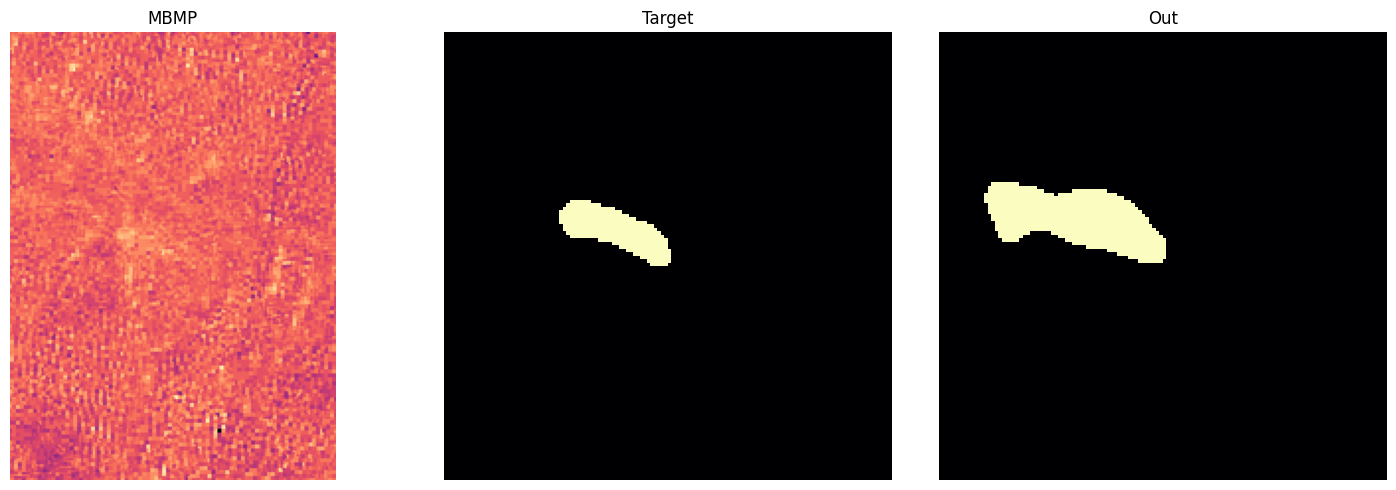

pos
27.838104710919936


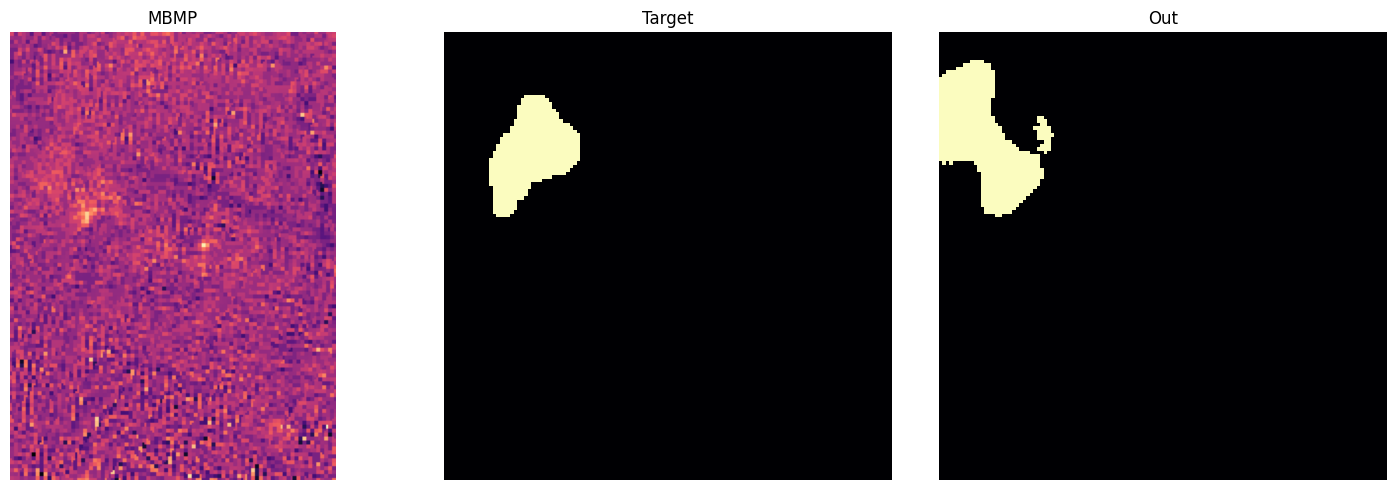

pos
42.39130442609877


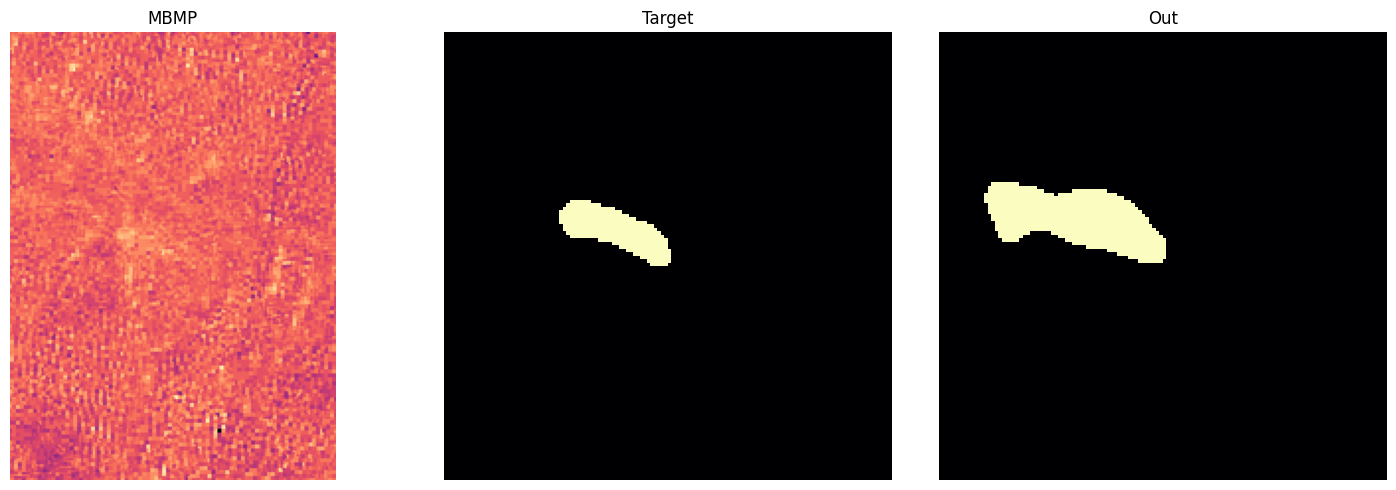

pos
47.12535348998552


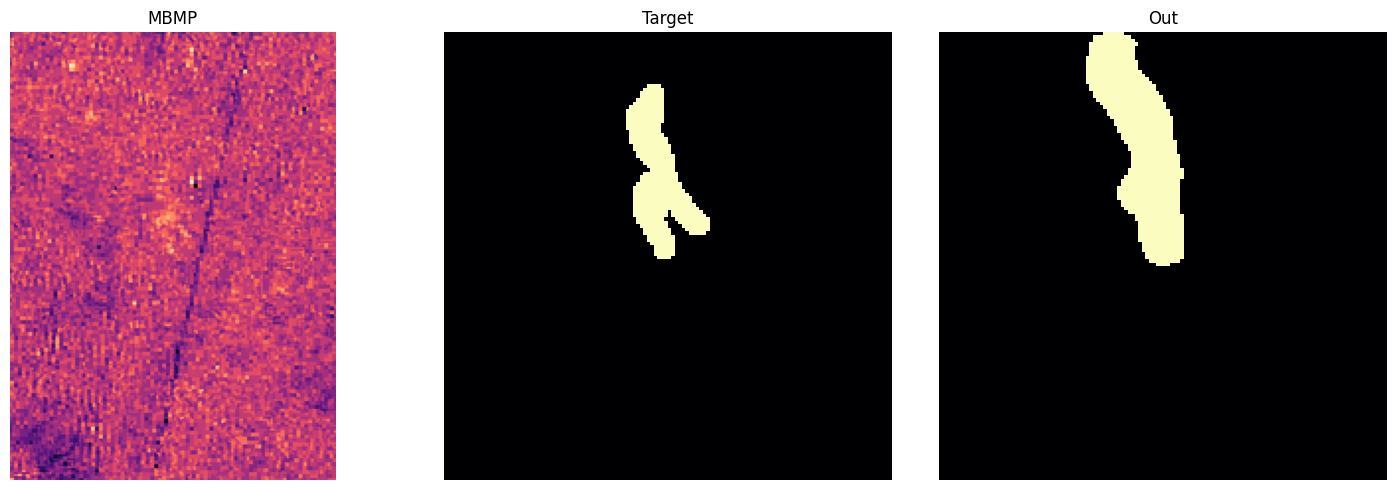

neg
100.0


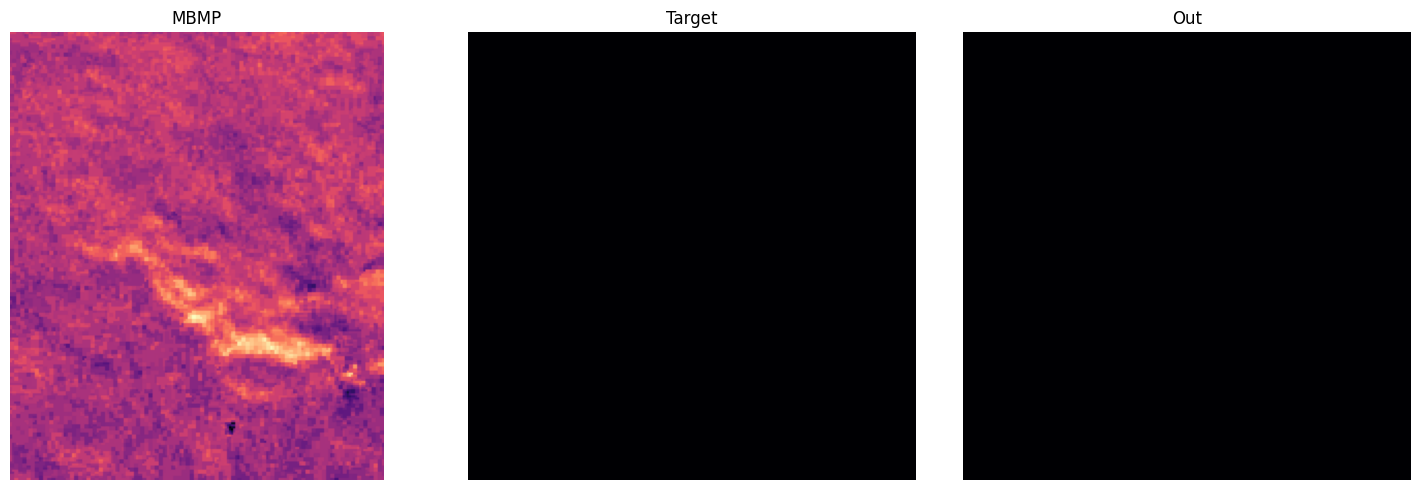

pos
35.65400850669408


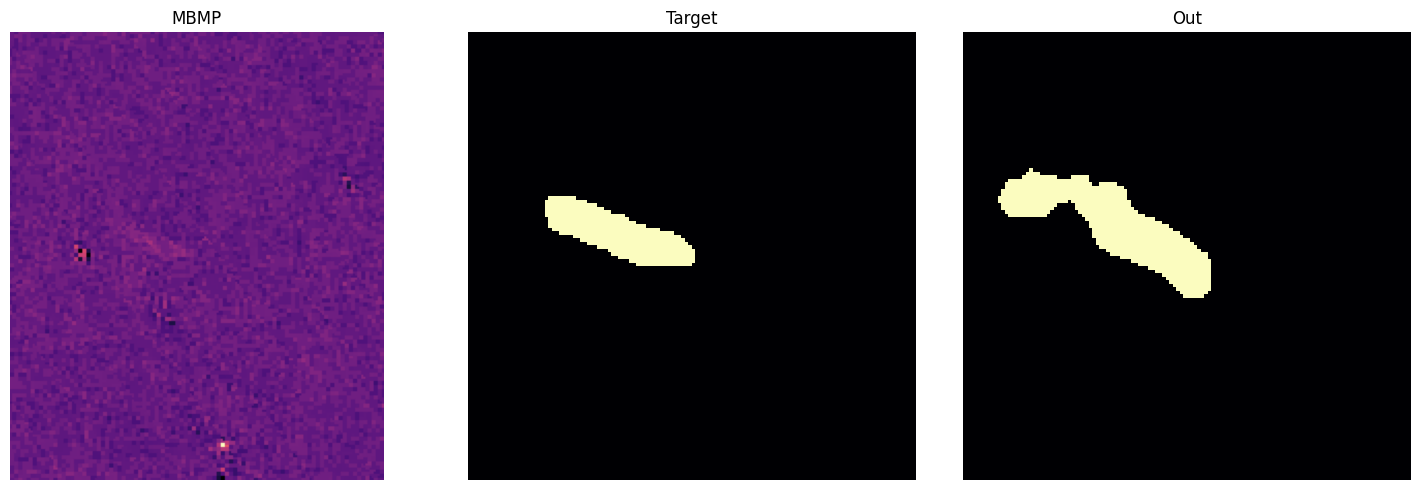

pos
29.480381835121545


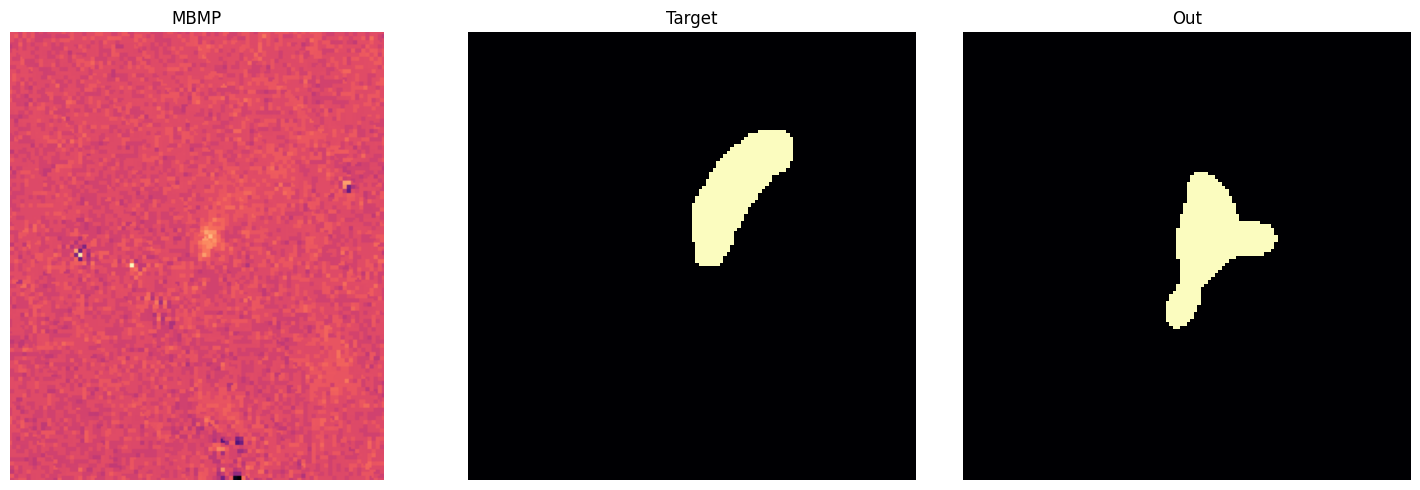

pos
33.49131132149872


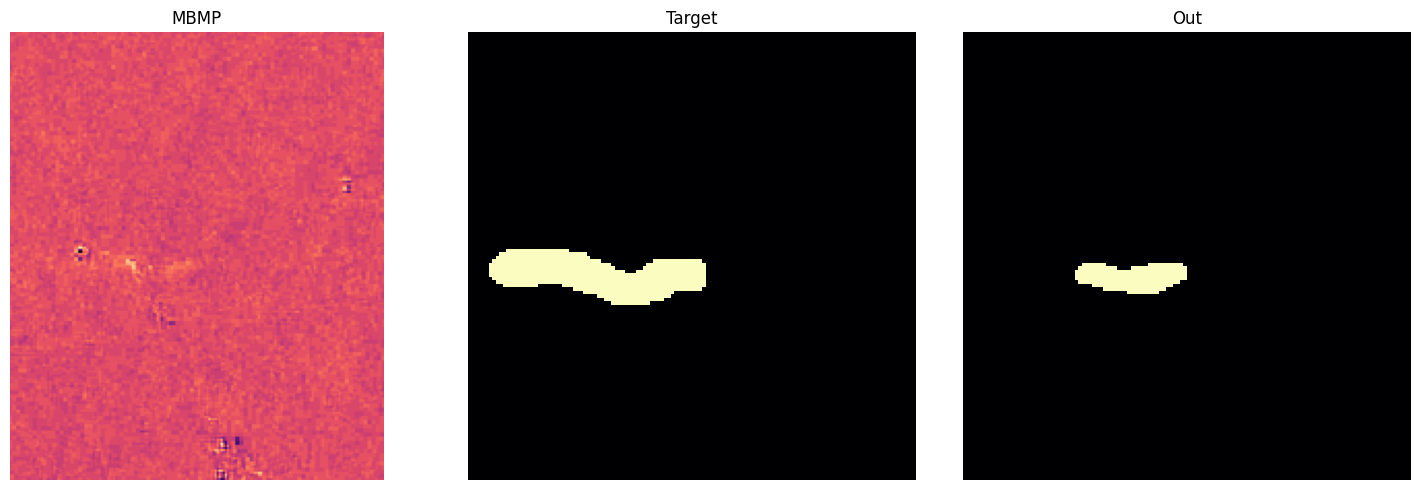

pos
3.4013605326484333e-07


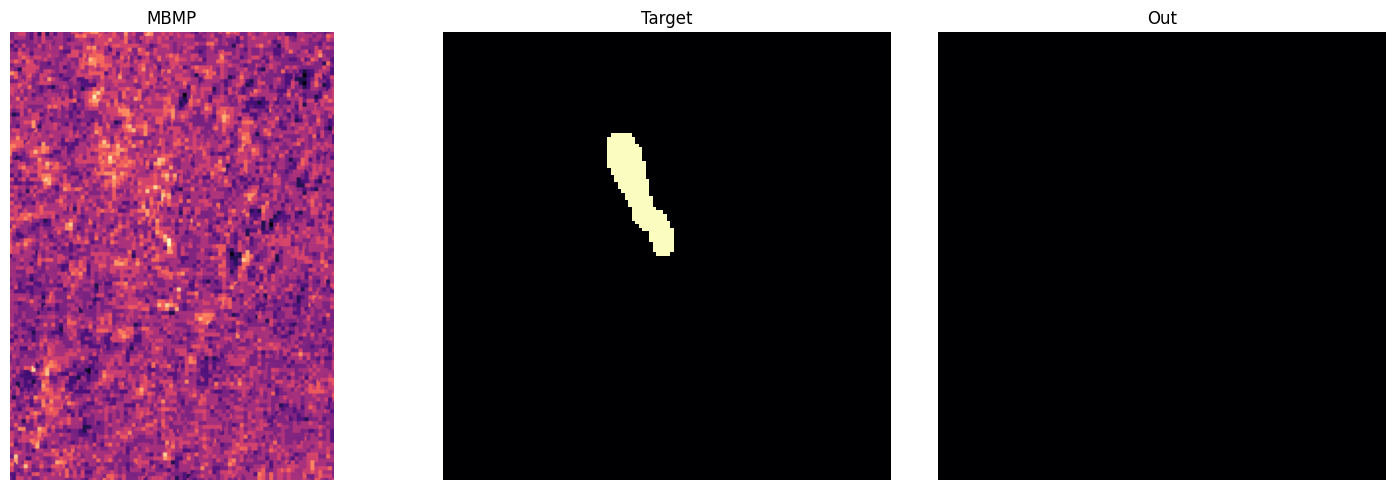

pos
41.98405673872094


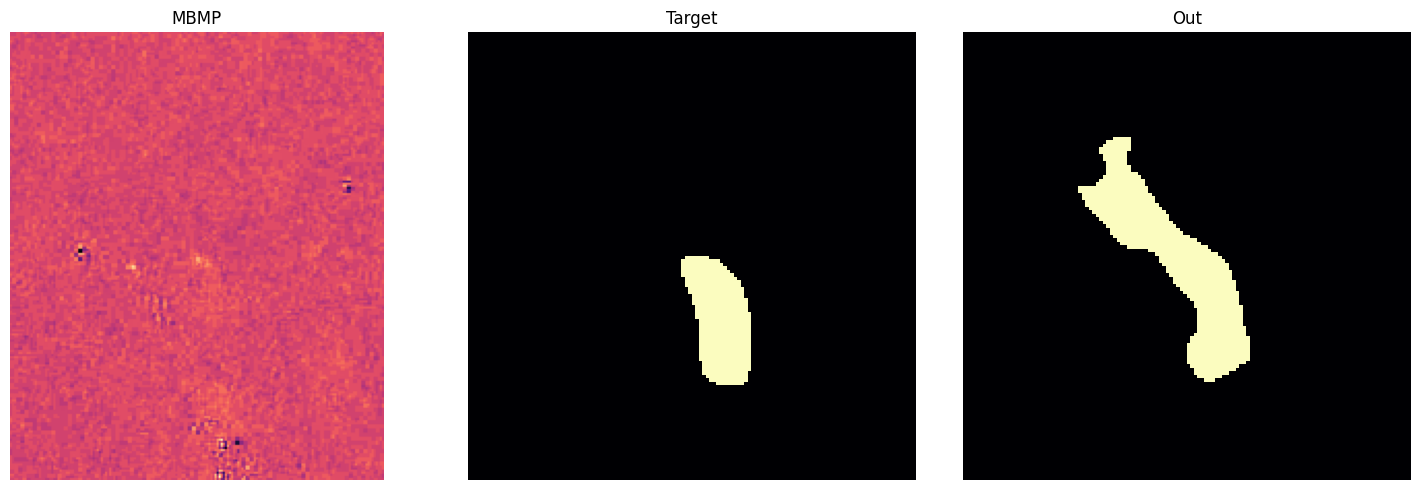

pos
49.75247530971229


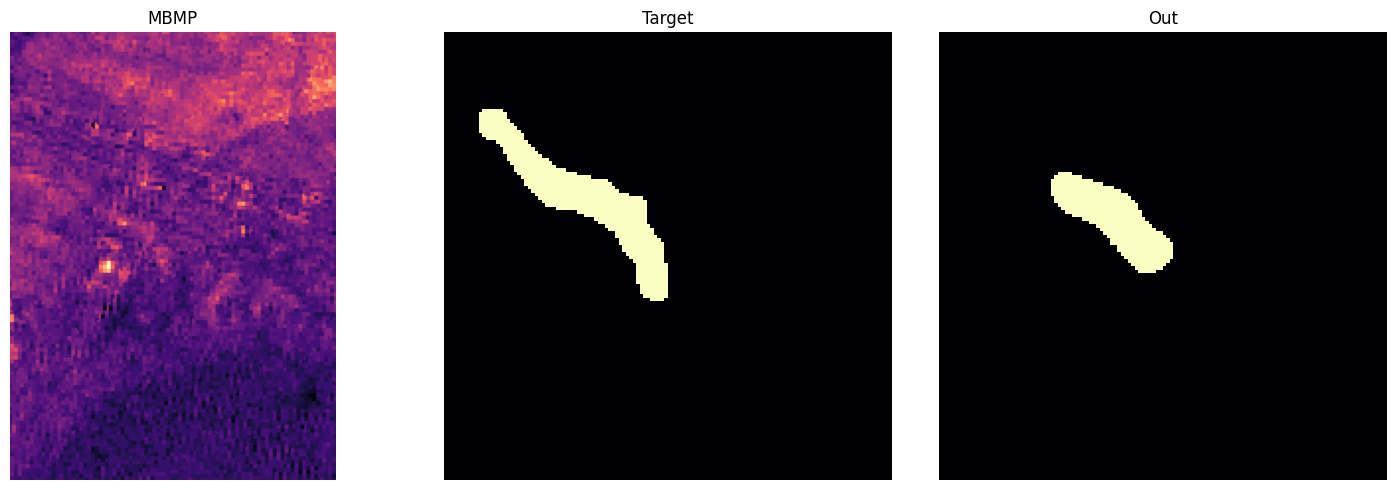

neg
7.407407352537723e-07


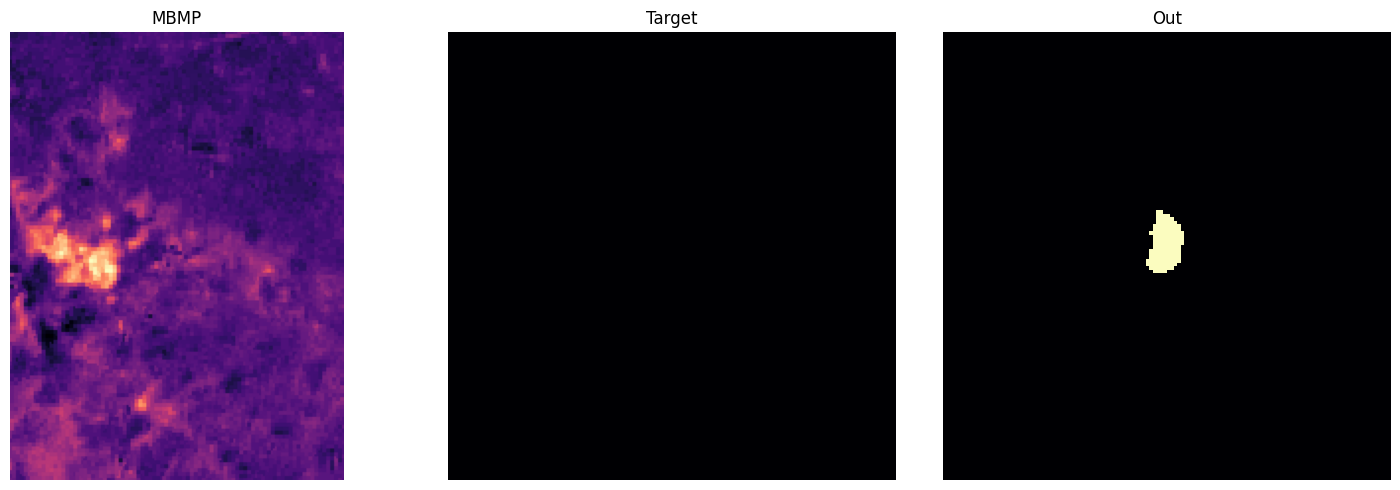

neg
100.0


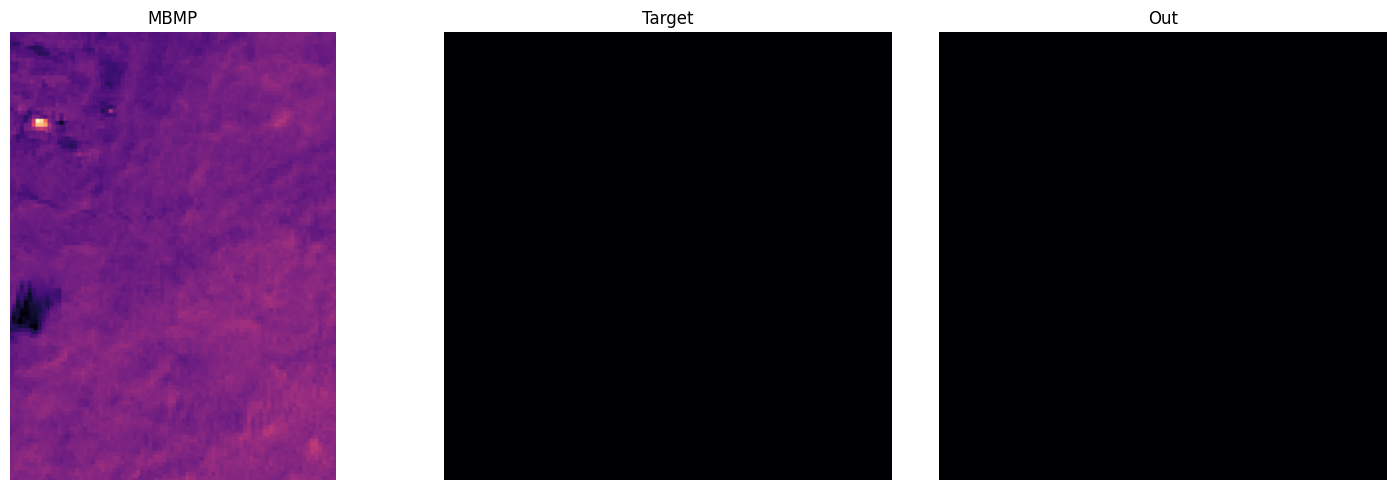

neg
100.0


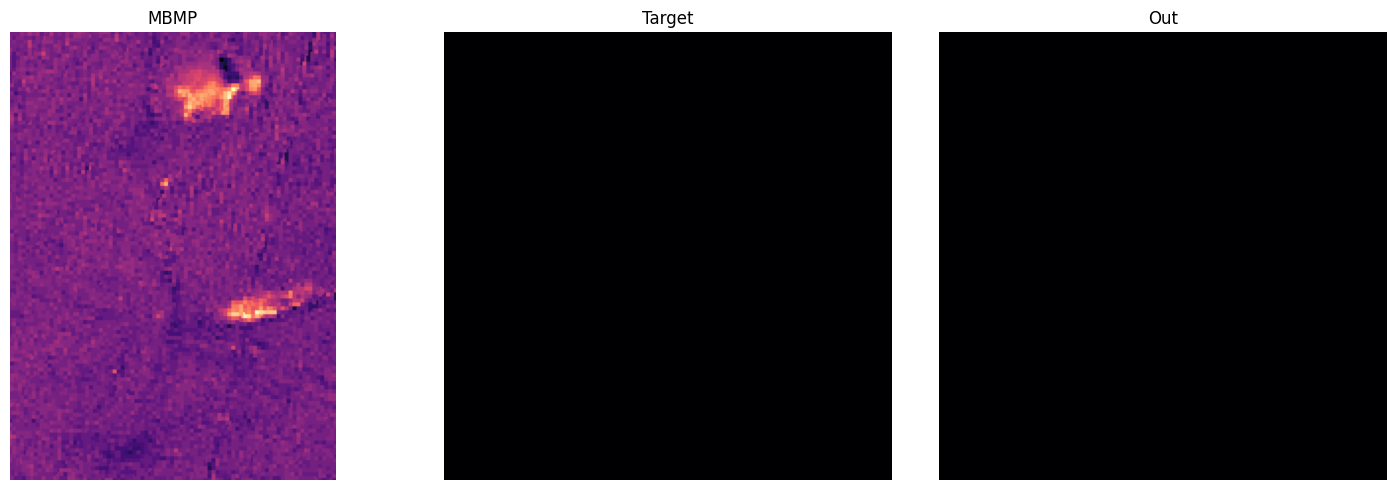

pos
22.690763207448267


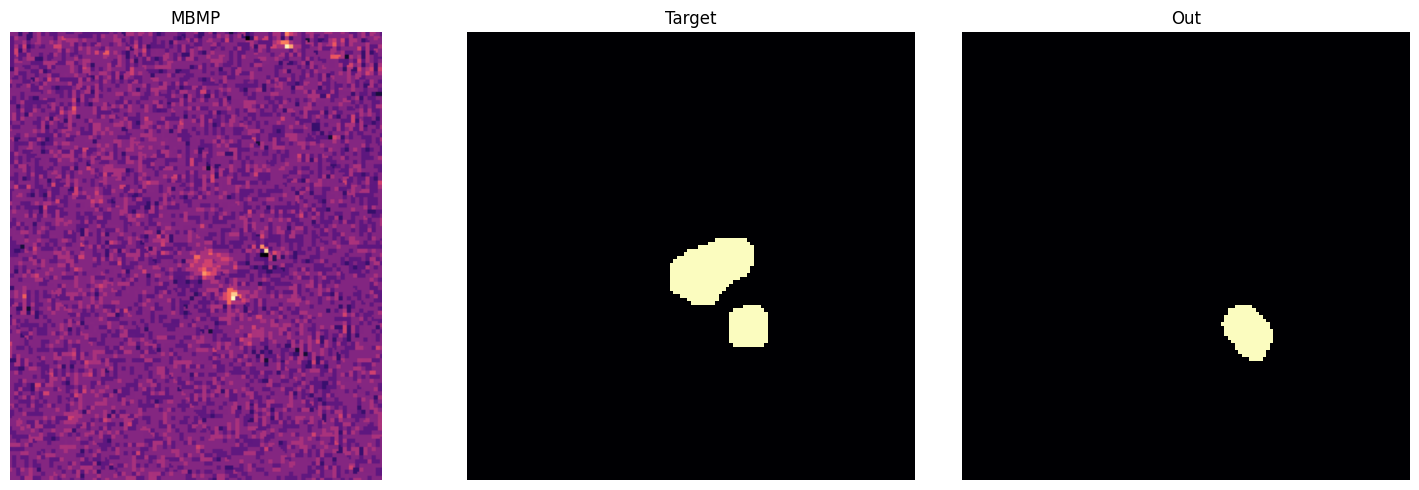

neg
100.0


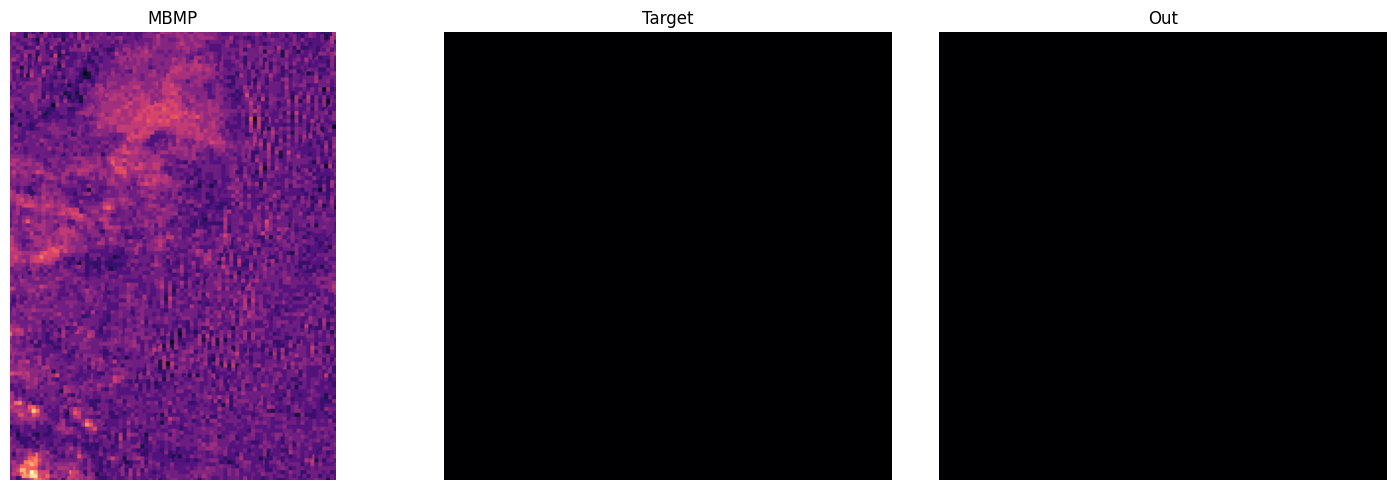

pos
63.60808714835445


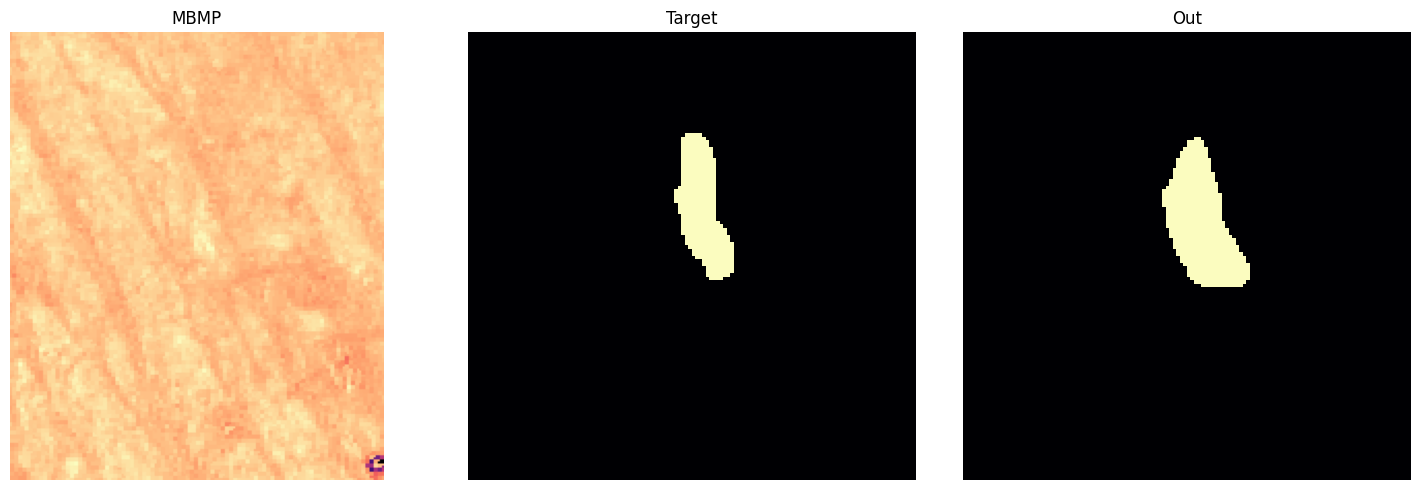

neg
100.0


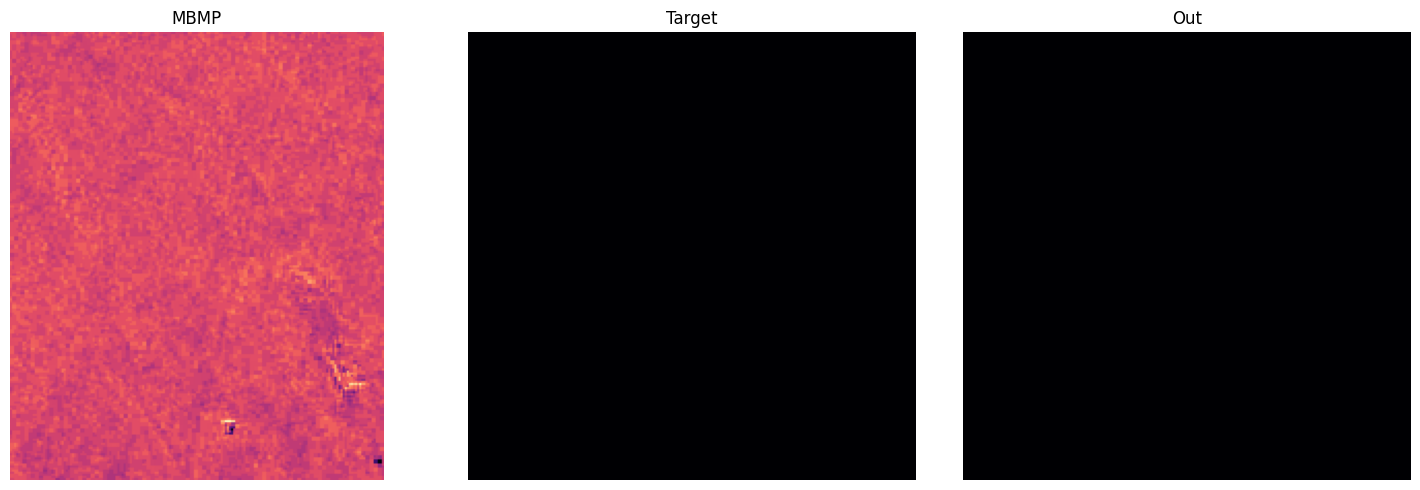

pos
45.118191217761364


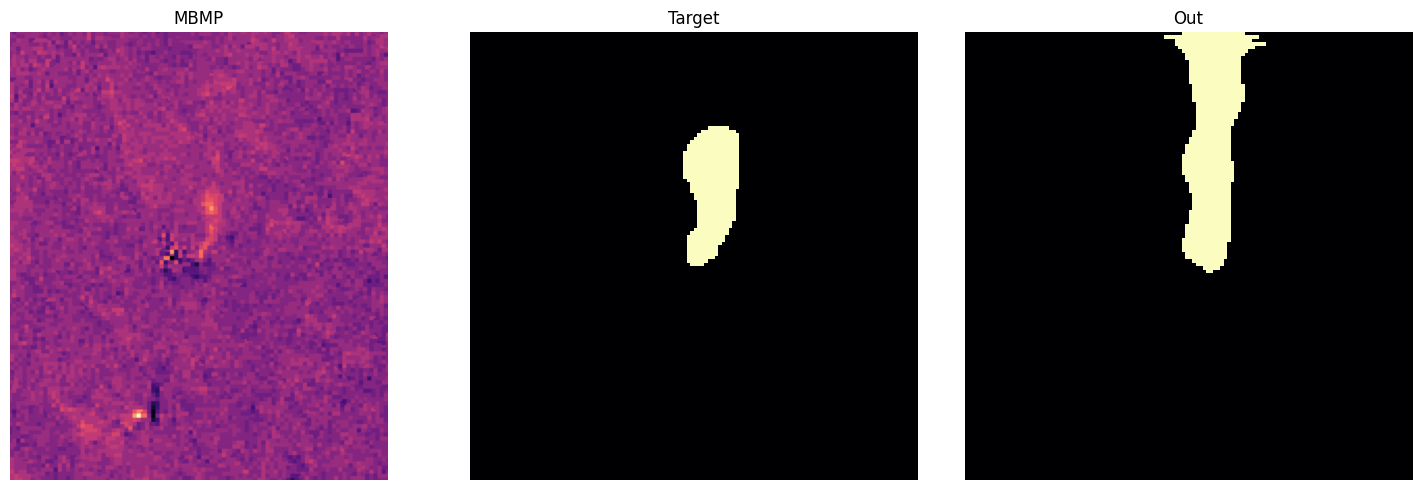

pos
54.95716039784925


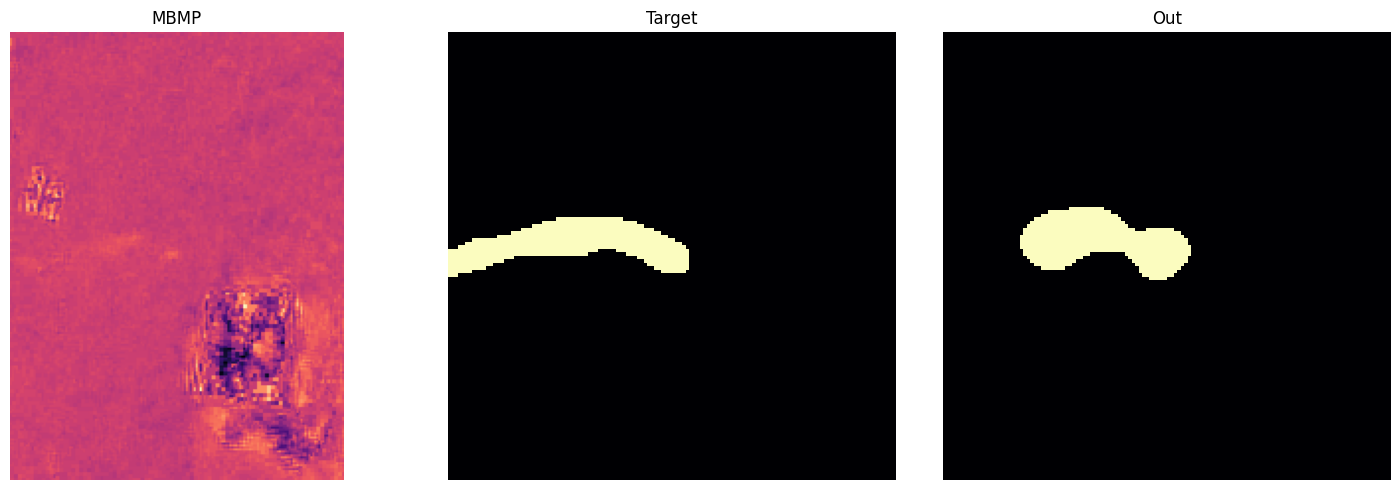

In [16]:
# from glob import glob

# visualize masks
samples = 250

# def visualize(idx):
    
for i in range(samples):
    idx = np.random.randint(0, samples)
#     idx = i

    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)
#     print(image2.shape)
    
    eps = 1e-6
    pred = image3
    target = image2
    iou = (np.sum(np.logical_and(pred, target)) + eps) / (np.sum(np.logical_or(pred, target)) + eps) * 100
    
    print(iou)

#     print(image1.shape, image2.shape, image3.shape)
#     print(losses[idx])

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()
    
    i = i + 1
    if(i==20): break
